In [4]:
#first create a sample training image. Then worry about how to classify it
#can we use the same training set from task 1 for task 2, provided it's classified correctly

import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
class diagram:
    def __init__(self, data):
        self.data = data #this will be a 20x20 matrix

    @classmethod
    def createDiagram(cls):
        dgrm = cls(np.zeros((20,20), dtype=float))

        return dgrm
    
    def layWires(self):
        possibleRows = [] #possible rows to choose from when selecting one to lay down a wire
        for i in range(self.data.shape[0]): possibleRows.append(i)
        possibleColumns = [] #possible columns to choose from when selecting one to lay down a wire
        for i in range(self.data.shape[1]): possibleColumns.append(i)

        colors = [1,2,3,4] #1 is red, 2 is blue, 3 is yellow, 4 is green
        layRowFirst = random.randrange(2) #0 indicates false, 1 indicates true
        for i in range(4):
            color = colors.pop(random.randrange(len(colors)))
            if i%2 == 0:
                if layRowFirst == 1:
                    row = possibleRows.pop(random.randrange(len(possibleRows)))
                    for j in range(self.data.shape[0]): self.data[row][j] = color
                else:
                    col = possibleColumns.pop(random.randrange(len(possibleColumns)))
                    for j in range(self.data.shape[1]): self.data[j][col] = color
            else:
                if layRowFirst == 1:
                    col = possibleColumns.pop(random.randrange(len(possibleColumns)))
                    for j in range(self.data.shape[1]): self.data[j][col] = color
                else:
                    row = possibleRows.pop(random.randrange(len(possibleRows)))
                    for j in range(self.data.shape[0]): self.data[row][j] = color

    def showDiagram(self):
        colors = ['white', 'red', 'blue', 'yellow','green']
        custom_map = ListedColormap(colors)
        bounds = [-.1, .5, 1.5, 2.5, 3.5, 4.5]
        norm = BoundaryNorm(bounds, custom_map.N)
        plt.imshow(self.data, cmap = custom_map, norm=norm)
        
        #Ensure shows plot with increments of 1
        plt.xticks(np.arange(-0.5, self.data.shape[1], 1), labels=[])
        plt.yticks(np.arange(-0.5, self.data.shape[0], 1), labels=[])

        #Show gridlines 
        plt.grid(True)

        #Show colorbar
        plt.colorbar()
        plt.show()

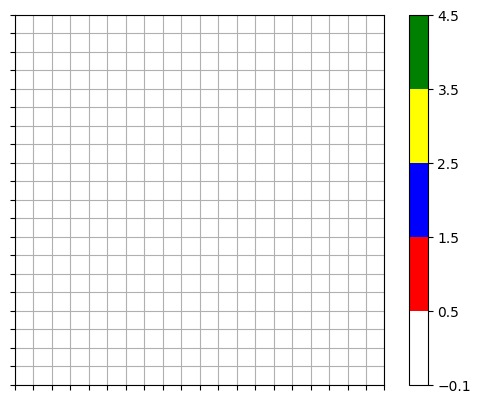

In [6]:
dgrm = diagram.createDiagram()
dgrm.layWires()
dgrm.showDiagram()